#### Since I do not have access to the customer subscriptions, I just created a dummy one.

In [808]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from scipy import stats
plt.style.use('fivethirtyeight') 

#Reading only the dates and discarding the time 
dateparse = lambda x: pd.datetime.strptime(x[:10],'%Y-%m-%d')
customer_demographics = pd.read_csv("https://assets.datacamp.com/production/repositories/1646/datasets/01054025eb094ac1086edf8d206b313b84d911c5/user_demographics_paywall.csv" \
                                 ,parse_dates=['reg_date'], date_parser=dateparse)



#Creating the customer subscription data-set
def random_dates(start, end, n, unit='D', seed=None):
    if not seed:  
        np.random.seed(0)

    ndays = (end - start).days + 1
    return pd.to_timedelta(np.random.rand(n) * ndays, unit=unit) + start

start = pd.to_datetime(customer_demographics.reg_date.min())
end = pd.to_datetime(customer_demographics.reg_date.max())

data ={
 "uid" : customer_demographics.uid,
 "lapse_date":random_dates(start,end,customer_demographics.shape[0]),
 "subscription_date":random_dates(start + timedelta(2),end, customer_demographics.shape[0]),
 "price":list(np.random.randint(400,500,customer_demographics.shape[0]))
 }
customer_subscriptions = pd.DataFrame(data)
customer_subscriptions[['lapse_date','subscription_date']] = customer_subscriptions[['lapse_date','subscription_date']].apply(lambda x: x.dt.strftime("%Y-%m-%d"))
customer_subscriptions.set_index('uid', inplace = True)




#creating random null values
index = customer_subscriptions.sample(frac=0.05, random_state=1).index
for i in index:
    customer_subscriptions.iloc[index.get_loc(i),np.random.randint(1,3)] = np.nan

#Merging the two datasets
demo_agg = customer_demographics.merge(customer_subscriptions, how='inner', on=['uid'])
demo_agg.set_index('uid',inplace =True)


## EDA

In [809]:
demo_agg.info()
demo_agg.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 52774929 to 32942475
Data columns (total 8 columns):
reg_date             1100 non-null datetime64[ns]
device               1100 non-null object
gender               1100 non-null object
country              1100 non-null object
age                  1100 non-null int64
lapse_date           1100 non-null object
subscription_date    1076 non-null object
price                1069 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 77.3+ KB


,age,price
count,1100.000000,1069.000000
mean,24.798182,448.579046
std,10.689479,28.691870
min,15.000000,400.000000
25%,17.000000,423.000000
50%,21.000000,448.000000
75%,29.000000,473.000000
max,85.000000,499.000000


In [810]:
demo_agg.isnull().sum()

reg_date              0
device                0
gender                0
country               0
age                   0
lapse_date            0
subscription_date    24
price                31
dtype: int64

In [811]:
demo_agg.head()

,reg_date,device,gender,country,age,lapse_date,subscription_date,price
uid,,,,,,,,
52774929,2018-03-07,and,F,FRA,27,2016-10-20,2016-10-20,NaN
40143397,2016-07-02,and,F,DEU,56,2017-04-27,NaN,429.0
89856430,2017-06-05,and,M,TUR,31,2016-12-20,NaN,428.0
76188504,2016-09-24,iOS,M,BRA,54,2016-10-15,2016-10-16,NaN
76493748,2017-06-07,iOS,M,BRA,24,2016-05-30,2016-05-31,NaN


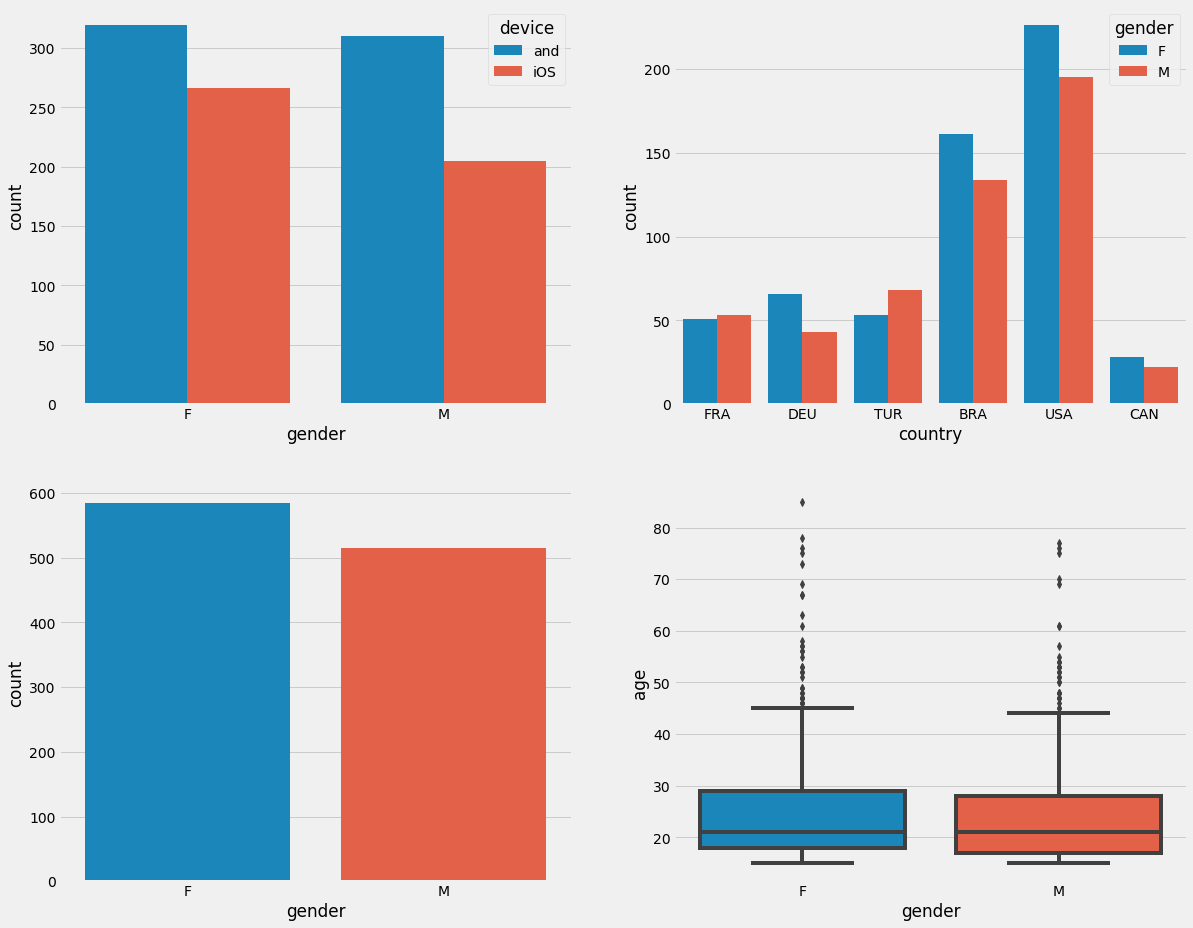

In [812]:
f,ax=plt.subplots(2,2,figsize=(18,15))
sns.countplot(demo_agg.gender, hue=demo_agg.device,ax=ax[0][0])
sns.countplot(demo_agg.country, hue=demo_agg.gender, ax = ax[0][1])
sns.countplot(demo_agg.gender, ax = ax[1][0])
sns.boxplot(y= demo_agg.age,x=demo_agg.gender,ax = ax[1][1])

In [813]:
demo_agg.gender.value_counts()

F    585
M    515
Name: gender, dtype: int64

### Dealing with missing variables

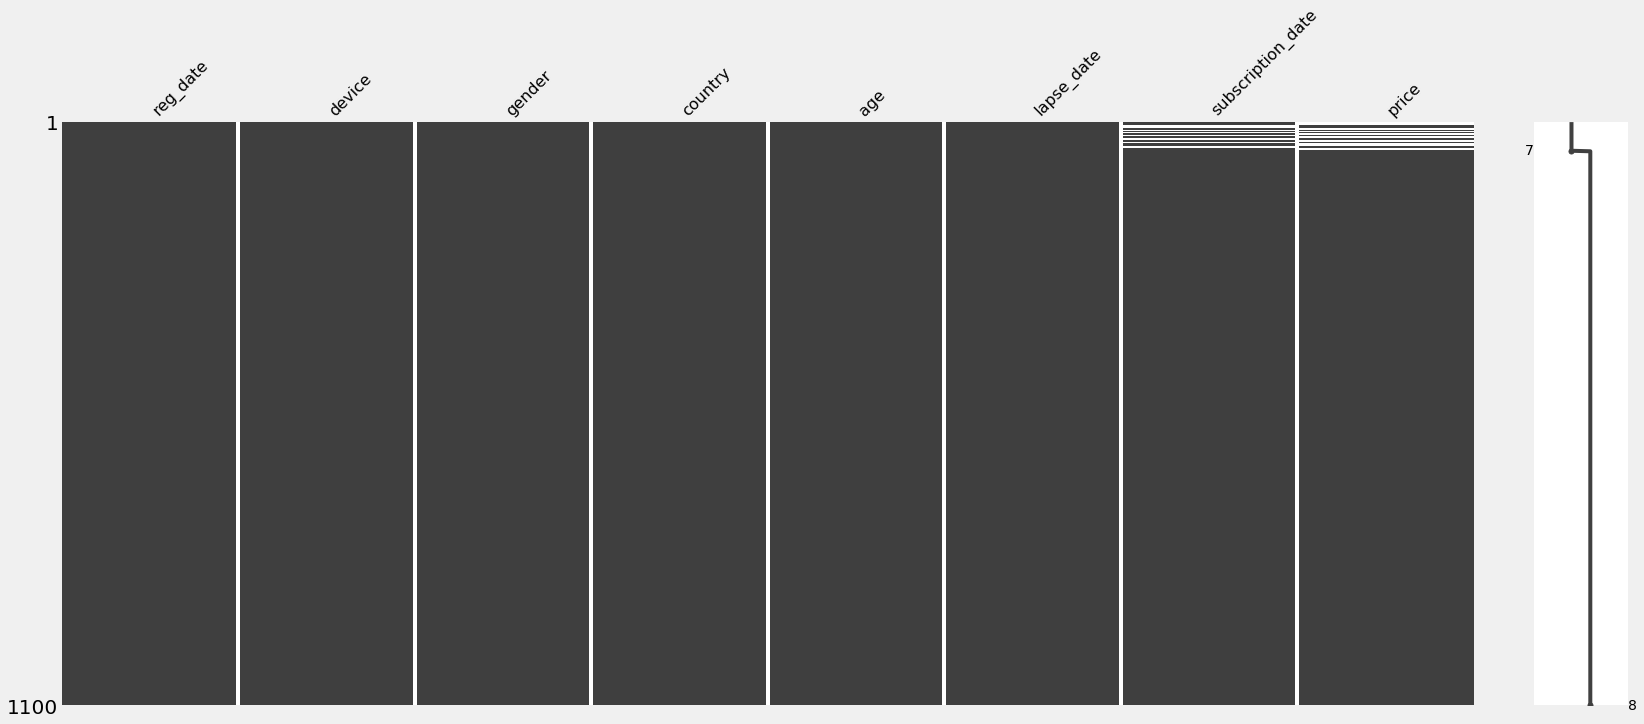

In [814]:
a = demo_agg.isnull()
msno.matrix(demo_agg)

([<matplotlib.patches.Wedge at 0x1a51cc08d0>,
 [Text(-1.099888859966758, 0.015636358943992047, 'Total'),
  Text(1.2998686527150207, -0.018479331395843755, 'missing')])

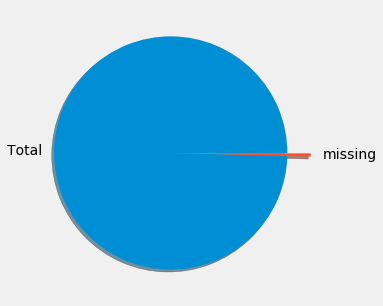

In [815]:
#The percentage of missing values to the total is 5% so it is alright to drop it.
percentage_of_missing_values=demo_agg.isnull().sum().sum() / demo_agg.shape[0] *100
demo_agg.shape[0]
f,xa = plt.subplots(figsize=(5,5))
plt.pie([demo_agg.shape[0],percentage_of_missing_values], labels=['Total','missing'],explode=(0,0.2),shadow=True)

In [734]:
#Dropping all of the null values
demo_agg=demo_agg.dropna()
demo_agg.isnull().sum().sum()

0

### A/B testing

In [817]:
demo_agg[["reg_date","lapse_date"]].max()
current_date = "2018-03-17"
max_lapse_date = current_date - timedelta(7)
max_lapse_date

TypeError: unsupported operand type(s) for -: 'str' and 'datetime.timedelta'

In [793]:
customer_subscriptions.subscription_date

0      2016-10-20 21:40:47.449171200
1      2017-04-27 17:45:30.023971199
2      2016-12-21 03:16:27.711062400
3      2016-10-16 10:37:04.457366400
4      2016-05-31 20:21:24.242400000
                    ...             
1095   2017-06-16 10:44:21.377241600
1096   2015-02-25 08:43:39.524505600
1097   2018-02-07 14:34:33.486355200
1098   2017-01-04 02:10:49.735574400
1099   2016-10-25 00:26:23.880998400
Name: subscription_date, Length: 1100, dtype: datetime64[ns]